In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from src.utils.visualization import plot_comparison_histogram
from src.utils.evaluation import ModelEvaluator
from src.utils.transform import (HourExtractor, WeekendExtractor, 
    FeatureCrosser, FringeCategoryBucketer)
from src.models.baseline import BaselineClassifier

In [3]:
cfg = OmegaConf.load('../config.yaml')

In [4]:
processed_data_dir = '..' / pathlib.Path(cfg.paths.data.processed)
processed_file = processed_data_dir / cfg.files.processed_dataset

df = pd.read_csv(processed_file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38182 entries, 0 to 38181
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              33983 non-null  float64
 1   long             33983 non-null  float64
 2   download_mbit    38182 non-null  float64
 3   upload_mbit      38182 non-null  float64
 4   ping_ms          38180 non-null  float64
 5   lte_rsrp         23828 non-null  float64
 6   signal_strength  1335 non-null   float64
 7   platform         38182 non-null  object 
 8   network_name     24556 non-null  object 
 9   time_utc         38182 non-null  object 
 10  cat_technology   38182 non-null  object 
dtypes: float64(7), object(4)
memory usage: 3.2+ MB


## Train Test Split

In [16]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

## Baseline Model

In [17]:
# We define upper limits for download speed
# as thresholds for the baseline model.
# E.g., if download-speed is less than
# 20 mbit/s, we assume its 3G,
# if it is between 20 and 150 mbit/s
# we say 4G, and beyond that we will return 5G
upper_limits = {
    '3G': 20,
    '4G': 150,
}

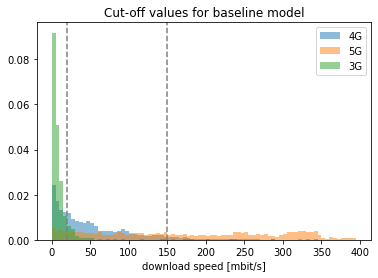

In [18]:
plot_comparison_histogram(
    X_train.download_mbit,
    y_train,
    bins=np.arange(0,400,5),
    vlines=upper_limits.values(),
    title='Cut-off values for baseline model',
    xlabel='download speed [mbit/s]'
)

In [19]:
baseline = BaselineClassifier(col_index=2,
                              upper_limits=upper_limits)

baseline.fit(X_train, y_train)

y_test_baseline = baseline.predict(X_test)

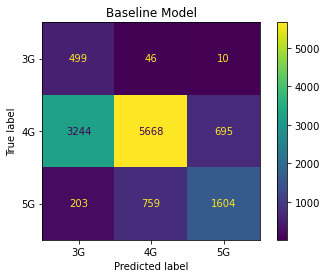

              precision    recall  f1-score   support

          3G       0.13      0.90      0.22       555
          4G       0.88      0.59      0.70      9607
          5G       0.69      0.63      0.66      2566

    accuracy                           0.61     12728
   macro avg       0.57      0.70      0.53     12728
weighted avg       0.81      0.61      0.67     12728



In [20]:
ModelEvaluator().get_summary(y_test, y_test_baseline, name='Baseline Model')